# Import modules

In [1]:
import torch
import torch.optim as optim
from pathlib import Path
import logging
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd

import seaborn as sns
from models.config_classes import Config
from models.autoencoder import KoopmanAutoencoder

from models.dataloader import create_dataloaders
from models.metrics import Metric
from models.utils import load_checkpoint, load_datasets, compute_all_metrics
from models.visualization import metrics_to_latex_table
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")

cmap = sns.color_palette("icefire", as_cmap=True)

# Configuration


In [2]:
CONFIG_PATH = Path("./model_outputs/128_inc_kl_1.0_linear/dummy-34eluxng/128_inc.yaml")
CKPT_PATH = Path("./model_outputs/128_inc_kl_1.0_linear/dummy-34eluxng/checkpoints/epoch_80.pth")
# CONFIG_PATH = Path("./model_outputs/128_inc_kl_1.0_eigen/dummy-polswpov/128_inc.yaml")
# CKPT_PATH = Path("./model_outputs/128_inc_kl_1.0_eigen/dummy-polswpov/checkpoints/epoch_80.pth")
# CONFIG_PATH = Path("./model_outputs/128_inc_kl_1.0_mlp/dummy-r5mrpxpo/128_inc.yaml")
# CKPT_PATH = Path("./model_outputs/128_inc_kl_1.0_mlp/dummy-r5mrpxpo/checkpoints/epoch_80.pth")
INITIAL_SAMPLE_INDEX = 500
ROLL_OUT_STEPS = 60
FRAME_STRIDE = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
base_config = OmegaConf.structured(Config)
file_config = OmegaConf.load(CONFIG_PATH)

cfg = OmegaConf.merge(base_config, file_config)
OmegaConf.resolve(cfg)
# cfg['training']['use_checkpoint'] = False  # Don't checkpoint during testing

train_dataset, val_dataset, test_dataset = load_datasets(cfg)
train_loader, val_loader, test_loader = create_dataloaders(
            train_dataset, val_dataset, test_dataset, cfg.training
        )

2025-07-22 02:51:28,875 [INFO] Obstacle mask found and processed from static variables.
2025-07-22 02:51:29,853 [INFO] Fitted MeanStdNormalizer.
2025-07-22 02:51:31,932 [INFO] Filtering 19 simulations → 1 with Re=980.0
2025-07-22 02:51:33,140 [INFO] Obstacle mask found and processed from static variables.
2025-07-22 02:51:33,154 [INFO] Fitted MeanStdNormalizer.
2025-07-22 02:51:33,178 [INFO] Filtering 2 simulations → 1 with Re=490.0
2025-07-22 02:51:33,373 [INFO] Obstacle mask found and processed from static variables.
2025-07-22 02:51:33,391 [INFO] Fitted MeanStdNormalizer.
2025-07-22 02:51:33,410 [INFO] Successfully loaded datasets with type 'QGDatasetMultiSim'.


#  Load Model 


In [4]:
model = KoopmanAutoencoder(
            data_variables=cfg.data.variables,
            input_frames=cfg.data.input_sequence_length,
            height=cfg.model.height,
            width=cfg.model.width,
            latent_dim=cfg.model.latent_dim,
            operator_mode=cfg.model.operator_mode,
            hidden_dims=cfg.model.hidden_dims,
            transformer_config=cfg.model.transformer,
            use_checkpoint=cfg.training.use_checkpoint,
            predict_re=cfg.model.predict_re,
            re_grad_enabled=cfg.model.re_grad_enabled,
            **cfg.model.conv_kwargs,
        ).to(DEVICE)
model_params = model.parameters()
optimizer = optim.Adam(model_params, lr=cfg.lr_scheduler.lr)
if CKPT_PATH is not None:
    print(f"Loading from checkpoint: {CKPT_PATH}")
    model, _, _, _ = load_checkpoint(CKPT_PATH, model=model, optimizer=optimizer)

model.eval()

2025-07-22 02:51:33,709 [INFO] Checkpoint loaded from model_outputs/128_inc_kl_1.0_linear/dummy-34eluxng/checkpoints/epoch_80.pth. Resuming from epoch 81.


Loading from checkpoint: model_outputs/128_inc_kl_1.0_linear/dummy-34eluxng/checkpoints/epoch_80.pth


KoopmanAutoencoder(
  (history_encoder): HistoryEncoder(
    (linear): Linear(in_features=8192, out_features=256, bias=True)
    (layers): Sequential(
      (0): ConvBlock(
        (stack): ModuleList(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (3): ReLU()
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock(
        (stack): ModuleList(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (3): ReLU()
        )
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ConvBlock(
        (st

#  Run Rollout


In [5]:
def run_long_rollout(model, input_seq, rollout_steps):
    input_seq = input_seq.unsqueeze(0).to(DEVICE)  # [1, T, C, H, W]

    with torch.no_grad():
        out = model(input_seq, seq_length=rollout_steps)

    return out  # [T+rollout_steps, C, H, W]

#  Visualize


In [6]:
# input_seq, ground_truth, metadata = test_dataset[INITIAL_SAMPLE_INDEX, ROLL_OUT_STEPS]
input_seq, ground_truth, metadata = val_dataset[INITIAL_SAMPLE_INDEX, ROLL_OUT_STEPS]
input_seq["obstacle_mask"] = metadata["obstacle_mask"][0].repeat(*input_seq.batch_size, 1, 1)
print(ground_truth)
total_predicted_seq = run_long_rollout(model, input_seq, ROLL_OUT_STEPS)
predicted_seq = total_predicted_seq.x_preds.cpu()
# print(total_predicted_seq)

TensorDict(
    fields={
        p: Tensor(shape=torch.Size([60, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([60, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([60, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([60]),
    device=None,
    is_shared=False)


#  Plot Results 


In [7]:
def compute_vorticity(vx, vy):
    vxDx, vxDy = torch.gradient(vx, dim=(1, 2))  # vx: [T, H, W]
    vyDx, vyDy = torch.gradient(vy, dim=(1, 2))
    # return vyDx - vxDy  # [T, H, W]
    return vxDx - vyDy  # [T, H, W]

def plot_rollout(gt_dict, pred_dict, variable_name, frame_stride=5):
    """
    Plots the rollout comparison between ground truth and predicted sequence for a given variable.

    Args:
        gt_dict (TensorDict): TensorDict of ground truth tensors [T, H, W] per variable.
        pred_dict (TensorDict): TensorDict of predicted tensors [T, H, W] per variable.
        variable_name (str): The key for the variable to visualize.
        frame_stride (int): Step between frames to plot.
    """
    # Remove batch dimension if present
    if gt_dict.batch_dims == 1 and gt_dict.batch_size[0] == 1:
        gt_dict = gt_dict.squeeze(0)
    if pred_dict.batch_dims == 1 and pred_dict.batch_size[0] == 1:
        pred_dict = pred_dict.squeeze(0)

    gt = gt_dict[variable_name]  # shape: [T, H, W]
    pred = pred_dict[variable_name]  # shape: [T, H, W]

    print(f"Stats for variable: {variable_name}")
    print(f"GT   | Min: {gt.min():.4f}, Max: {gt.max():.4f}, Mean: {gt.mean():.4f}, Std: {gt.std():.4f}")
    print(f"Pred | Min: {pred.min():.4f}, Max: {pred.max():.4f}, Mean: {pred.mean():.4f}, Std: {pred.std():.4f}")

    num_frames = min(gt.shape[0], pred.shape[0])
    indices = list(range(0, num_frames, frame_stride))
    num_plots = min(len(indices), 15)

    fig = plt.figure(figsize=(1.8 * num_plots, 7.5))
    spec = gridspec.GridSpec(3, num_plots + 1, width_ratios=[1] * num_plots + [0.05])

    for i, idx in enumerate(indices[:num_plots]):
        # ----- Ground Truth -----
        ax_gt = fig.add_subplot(spec[0, i])
        im_gt = ax_gt.imshow(gt[idx].cpu(), cmap=cmap)
        ax_gt.axis('off')
        plt.colorbar(im_gt, ax=ax_gt, fraction=0.046, pad=0.04)
        ax_gt.set_title(f"t={idx}", fontsize=10)

        # Add row label only above the first frame
        if i == 0:
            ax_gt.text(-0.2, 1.5, "Ground Truth", fontsize=12, fontweight='bold',
                    transform=ax_gt.transAxes, ha='left', va='bottom')

        # ----- Prediction -----
        ax_pred = fig.add_subplot(spec[1, i])
        im_pred = ax_pred.imshow(pred[idx].cpu(), cmap=cmap)
        ax_pred.axis('off')
        plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)

        if i == 0:
            ax_pred.text(-0.2, 1.1, "Prediction", fontsize=12, fontweight='bold',
                        transform=ax_pred.transAxes, ha='left', va='bottom')

        # ----- Error -----
        err = gt[idx] - pred[idx]
        ax_err = fig.add_subplot(spec[2, i])
        im_err = ax_err.imshow(err.cpu(), cmap=cmap)
        ax_err.axis('off')
        plt.colorbar(im_err, ax=ax_err, fraction=0.046, pad=0.04)

        if i == 0:
            ax_err.text(-0.2, 1.1, "Error", fontsize=12, fontweight='bold',
                        transform=ax_err.transAxes, ha='left', va='bottom')
    # Add shared colorbar
    # cbar_ax = fig.add_subplot(spec[:, -1])
    # fig.colorbar(im_pred, cax=cbar_ax)
    

    fig.suptitle(f"Koopman AE Rollout for Variable: {variable_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.4, 0.98, 0.95])
    plt.show()

true Re: (tensor(980.), 'target')
TensorDict(
    fields={
        p: Tensor(shape=torch.Size([60, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([60, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([60, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([60]),
    device=None,
    is_shared=False)
TensorDict(
    fields={
        p: Tensor(shape=torch.Size([1, 60, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([1, 60, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([1, 60, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([1, 60]),
    device=cpu,
    is_shared=False)
Stats for variable: p
GT   | Min: -0.0144, Max: 0.0123, Mean: 0.0005, Std: 0.0039
Pred | Min: -0.0144, Max: 0.0132, Mean: 0.0009, Std: 0.0040

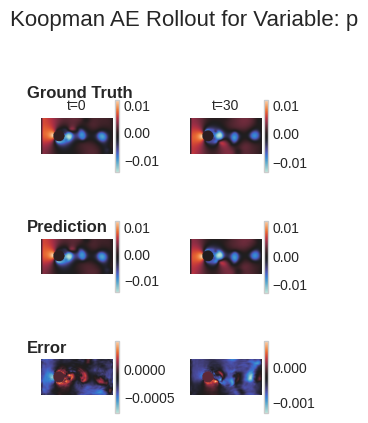

Stats for variable: v_x
GT   | Min: -0.4451, Max: 0.9588, Mean: 0.4430, Std: 0.2223
Pred | Min: -0.4177, Max: 0.9409, Mean: 0.4414, Std: 0.2181


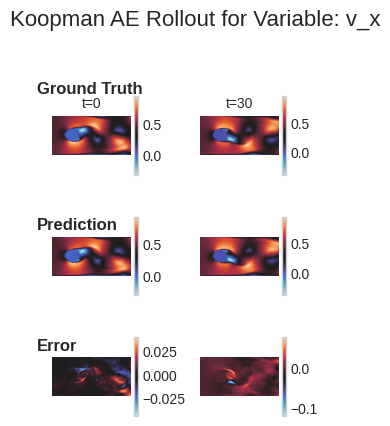

Stats for variable: v_y
GT   | Min: -0.6440, Max: 0.6461, Mean: 0.0015, Std: 0.1795
Pred | Min: -0.6488, Max: 0.6656, Mean: 0.0017, Std: 0.1844


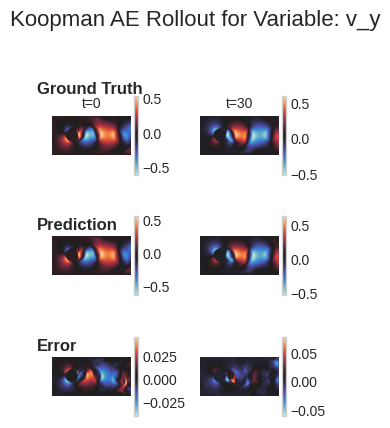

Stats for variable: vort
GT   | Min: -0.6106, Max: 0.5888, Mean: 0.0002, Std: 0.0757
Pred | Min: -0.6197, Max: 0.6036, Mean: 0.0002, Std: 0.0754


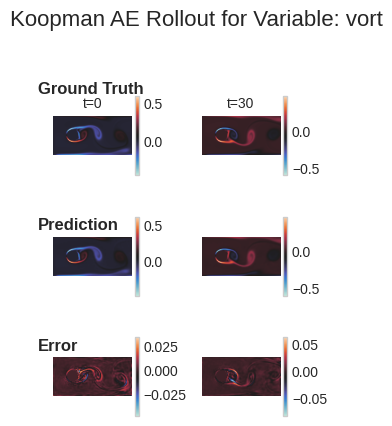

In [8]:
print(f'true Re: {metadata["Re"]}')
# print(f'pred Re: {total_predicted_seq.reynolds.squeeze().cpu()}')
# mean_re = total_predicted_seq.reynolds.squeeze().cpu().mean()
# print(f'average Re: {mean_re}')

# # Create the plot
# plt.figure(figsize=(10, 6))
# plt.axhline(metadata["Re"][0].item(), linestyle='--', label='True Re')
# plt.axhline(mean_re, linestyle='--', color='r', label='Mean Re')
# plt.plot(total_predicted_seq.reynolds.squeeze().cpu(), label='Pred Re', marker='o', linestyle='-')

# # --- Add axis labels ---
# plt.xlabel("Rollout Step")
# plt.ylabel("Reynolds Number (Re)")
# # ---

# plt.title("Predicted vs True Reynolds Number")
# plt.legend()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.show()

print(ground_truth)
print(predicted_seq)
ground_truth = test_loader.denormalize(ground_truth.unsqueeze(0)).squeeze()
predicted_seq = test_loader.denormalize(predicted_seq)

plot_rollout(ground_truth.cpu(), predicted_seq.squeeze().cpu(), variable_name="p", frame_stride=FRAME_STRIDE)
plot_rollout(ground_truth.cpu(), predicted_seq.squeeze().cpu(), variable_name="v_x", frame_stride=FRAME_STRIDE)
plot_rollout(ground_truth.cpu(), predicted_seq.squeeze().cpu(), variable_name="v_y", frame_stride=FRAME_STRIDE)

# Compute vorticity from vx and vy
vort_gt = compute_vorticity(ground_truth["v_x"], ground_truth["v_y"])
vort_pred = compute_vorticity(predicted_seq["v_x"].squeeze(), predicted_seq["v_y"].squeeze())

# Add derived vorticity to the TensorDicts
ground_truth["vort"] = vort_gt
predicted_seq["vort"] = vort_pred.unsqueeze(0)

# Plot vorticity
plot_rollout(ground_truth.squeeze().cpu(), predicted_seq.squeeze().cpu(), variable_name="vort", frame_stride=FRAME_STRIDE)

Setting up LSIM model from: models/lsim/models/LSiM.pth
Loading model from models/lsim/models/LSiM.pth
LSIM DistanceModel loaded successfully.

Long Rollout SSIM Metric: 0.019301


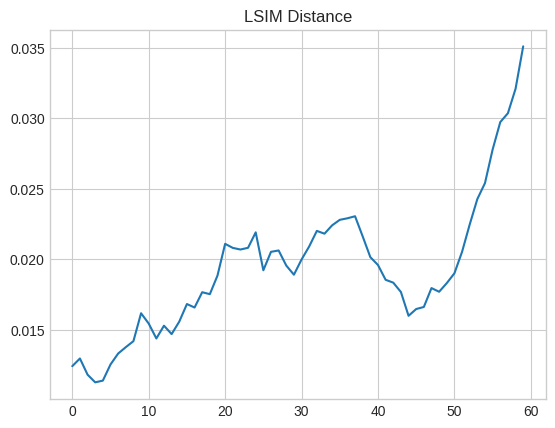

In [9]:
metric = Metric(
    mode="LSIM",
    # mode=cfg.metric.mode,
    variable_mode="single",
    variable_name="vort"
)
target_denorm = test_loader.denormalize(ground_truth.unsqueeze(0))
preds_denorm = test_loader.denormalize(predicted_seq)

metric_val = metric(
    test_loader.to_unit_range(target_denorm),
    test_loader.to_unit_range(preds_denorm),
)
print(f"\nLong Rollout {cfg.metric.mode} Metric: {metric_val.mean().item():.6f}")
plt.plot(metric_val.squeeze().cpu().detach().numpy())
plt.title('LSIM Distance')
plt.show()

In [10]:
# Denormalize predictions and targets
target_denorm = test_loader.denormalize(ground_truth.unsqueeze(0))
preds_denorm = test_loader.denormalize(predicted_seq)

# Get list of variables to evaluate
vars_to_eval = [k for k in target_denorm.keys() if k not in ["seq_length", "Re", "obstacle_mask"]]

# Add "vort" manually if it's computed on the fly
if "vort" not in vars_to_eval and "vort" in target_denorm:
    vars_to_eval.append("vort")

# Compute custom min/max for manually computed variables like vort
custom_min_max = {}
if "vort" in vars_to_eval:
    vort_min = target_denorm["vort"].min().item()
    vort_max = target_denorm["vort"].max().item()
    custom_min_max["vort"] = (vort_min, vort_max)

# Compute metrics
metrics_result = compute_all_metrics(
    target_denorm,
    preds_denorm,
    test_loader,
    vars_to_eval,
    custom_min_max=custom_min_max
)

# Generate and print LaTeX table
latex_table = metrics_to_latex_table(metrics_result)
print("\nLaTeX Table:\n")
print(latex_table)

# Save to file
with open("metrics_table_mlp.tex", "w") as f:
    f.write(latex_table)

Setting up LSIM model from: models/lsim/models/LSiM.pth
Loading model from models/lsim/models/LSiM.pth
LSIM DistanceModel loaded successfully.
Setting up LSIM model from: models/lsim/models/LSiM.pth
Loading model from models/lsim/models/LSiM.pth
LSIM DistanceModel loaded successfully.
Setting up LSIM model from: models/lsim/models/LSiM.pth
Loading model from models/lsim/models/LSiM.pth
LSIM DistanceModel loaded successfully.


Setting up LSIM model from: models/lsim/models/LSiM.pth
Loading model from models/lsim/models/LSiM.pth
LSIM DistanceModel loaded successfully.
Setting up LSIM model from: models/lsim/models/LSiM.pth
Loading model from models/lsim/models/LSiM.pth
LSIM DistanceModel loaded successfully.

LaTeX Table:

\begin{tabular}{lccccc}
Variable & L2 & SSIM & PSNR & VI & LSIM \\\hline
all & 1.21e-05 ± 1.01e-05 & 3.46e-03 ± 2.46e-03 & -6.05e+01 ± 1.98e+00 & 9.45e-01 ± 1.50e-01 & 2.92e-02 ± 6.56e-03 \\
p & 4.21e-12 ± 2.67e-12 & 3.55e-08 ± 2.72e-08 & -9.00e+01 ± 1.15e-02 & 0.00e+00 ± 0.00e+00 & 0.00e+00 ± 0.00e+00 \\
v_x & 8.42e-06 ± 6.76e-06 & 1.35e-03 ± 1.15e-03 & -5.19e+01 ± 3.21e+00 & 1.32e+00 ± 2.52e-01 & 3.51e-02 ± 1.22e-02 \\
v_y & 4.03e-06 ± 2.12e-06 & 4.74e-03 ± 3.36e-03 & -5.44e+01 ± 1.73e+00 & 9.07e-01 ± 1.87e-01 & 4.46e-02 ± 7.44e-03 \\
vort & 3.59e-05 ± 3.16e-05 & 7.73e-03 ± 5.37e-03 & -4.57e+01 ± 3.17e+00 & 1.55e+00 ± 1.70e-01 & 3.72e-02 ± 9.38e-03 \\
\end{tabular}


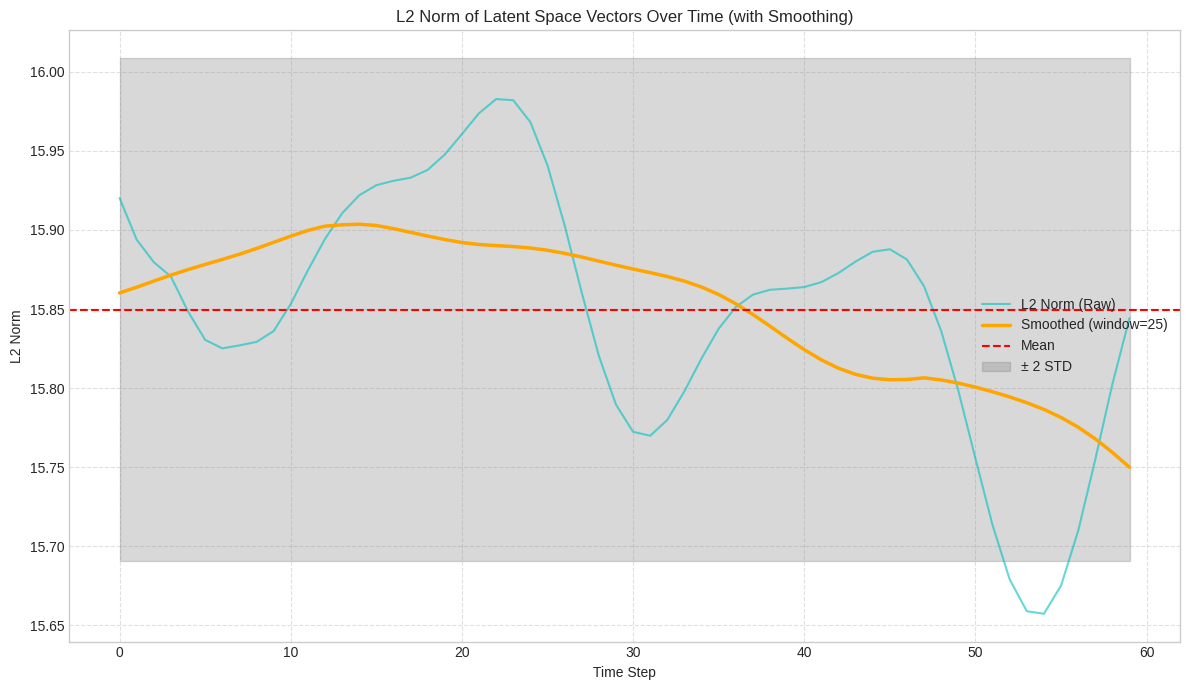

In [11]:

z_preds = total_predicted_seq.z_preds.cpu().detach()

if z_preds.ndim > 2:
    z_preds = z_preds.squeeze()

z_preds_cpu = z_preds.cpu().detach()[:90]
latent_norms = torch.norm(z_preds_cpu, dim=-1)
latent_mean = latent_norms.mean()
latent_std = latent_norms.std()

window_size = 25
latent_norms_series = pd.Series(latent_norms.numpy())

smoothed_norms = latent_norms_series.rolling(
    window=window_size,
    center=True,
    min_periods=1
).mean()

fig, ax = plt.subplots(figsize=(12, 7))

time_steps = range(len(latent_norms))
ax.plot(
    time_steps,
    latent_norms.numpy(),
    label='L2 Norm (Raw)',
    color='c',
    linewidth=1.5,
    alpha=0.6
)

ax.plot(
    time_steps,
    smoothed_norms,
    label=f'Smoothed (window={window_size})',
    color='orange',
    linewidth=2.5
)

ax.axhline(latent_mean.item(), color='r', linestyle='--', label='Mean')
upper_bound = latent_mean + 2 * latent_std
lower_bound = latent_mean - 2 * latent_std
ax.fill_between(
    time_steps,
    lower_bound.item(),
    upper_bound.item(),
    color='gray',
    alpha=0.3,
    label='± 2 STD'
)

ax.set_title("L2 Norm of Latent Space Vectors Over Time (with Smoothing)")
ax.set_xlabel("Time Step")
ax.set_ylabel("L2 Norm")
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend() # Add a legend to identify all lines

plt.tight_layout()
plt.show()

2025-07-22 02:51:39,243 [INFO] Matrix shape: (256, 256)


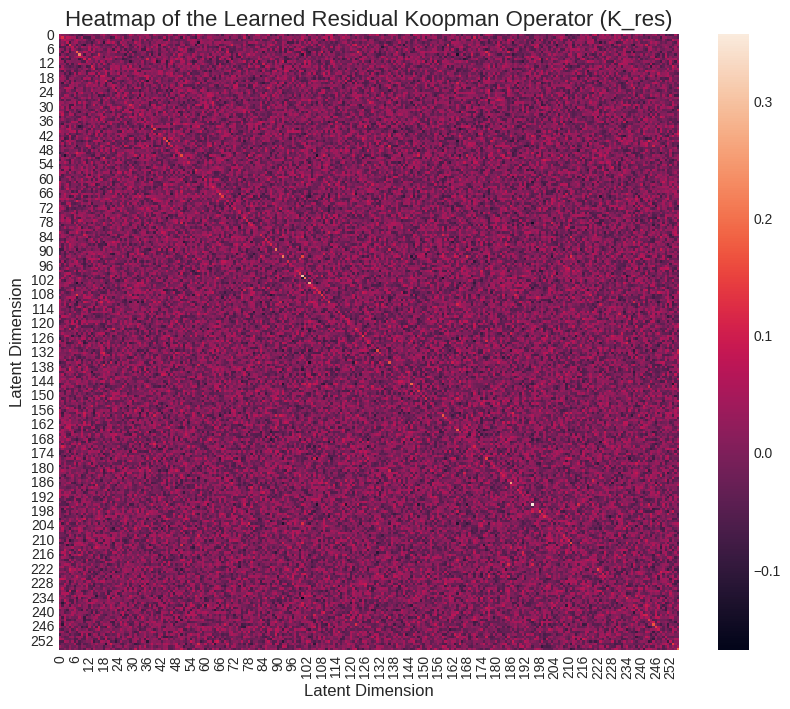

In [12]:
K_matrix = model.koopman_operator.koopman_linear.weight.T.detach().cpu().numpy()

logger.info(f"Matrix shape: {K_matrix.shape}")

# Visualize the matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(K_matrix)
plt.title("Heatmap of the Learned Residual Koopman Operator (K_res)", fontsize=16)
plt.xlabel("Latent Dimension", fontsize=12)
plt.ylabel("Latent Dimension", fontsize=12)
plt.show()

In [13]:
# eigenvectors = model.koopman_operator.eigenvectors.detach().cpu()#.numpy()
# eigenvalues = model.koopman_operator.eigenvalues.detach().cpu()#.numpy()

# if torch.is_complex(eigenvalues):
#     print("Complex eigenvalues detected. Using their magnitude for visualization.")
#     eigenvalues = eigenvalues.abs()

# # Create the diagonal matrix Lambda from the eigenvalues.
# Lambda = torch.diag(eigenvalues.to(torch.float32))

# # Get the transpose of the eigenvector matrix P.
# P_T = eigenvectors.T

# # Calculate the full Koopman matrix K.
# K_matrix_tensor = eigenvectors @ Lambda @ P_T

# # Convert the final tensor to a NumPy array for plotting.
# K_matrix = K_matrix_tensor.numpy()

# print(f"Constructed Koopman Matrix of shape: {K_matrix.shape}")

# # --- 3. Visualize the Matrix ---
# plt.figure(figsize=(12, 10))
# # Using a diverging colormap can be helpful to see positive/negative values
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# sns.heatmap(K_matrix, cmap=cmap, center=0)

# plt.title("Heatmap of the Reconstructed Koopman Operator (K)", fontsize=16)
# plt.xlabel("Latent Dimension", fontsize=12)
# plt.ylabel("Latent Dimension", fontsize=12)
# plt.show()

2025-07-22 02:51:39,527 [INFO] Computed 256 eigenvalues.


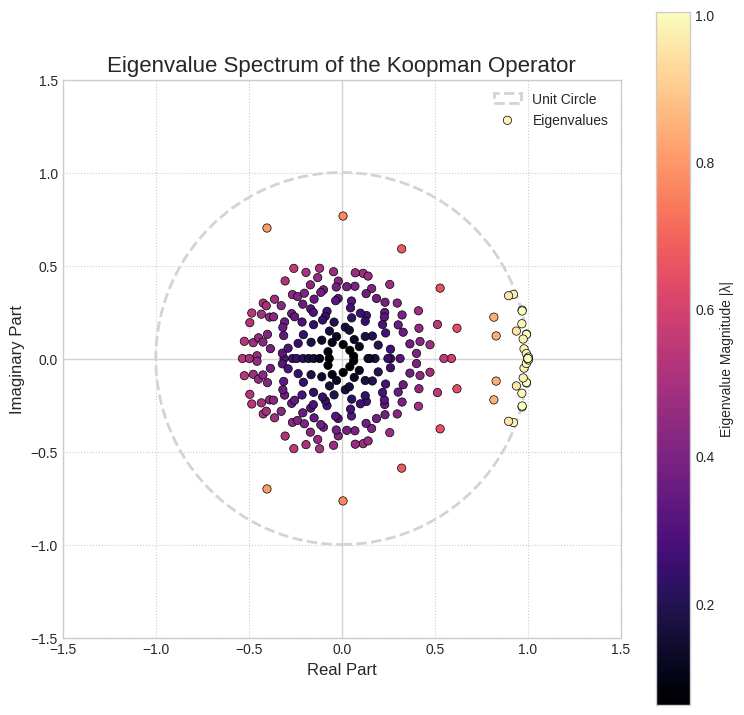

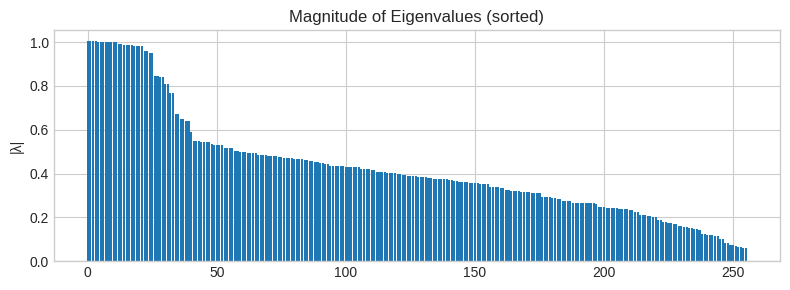

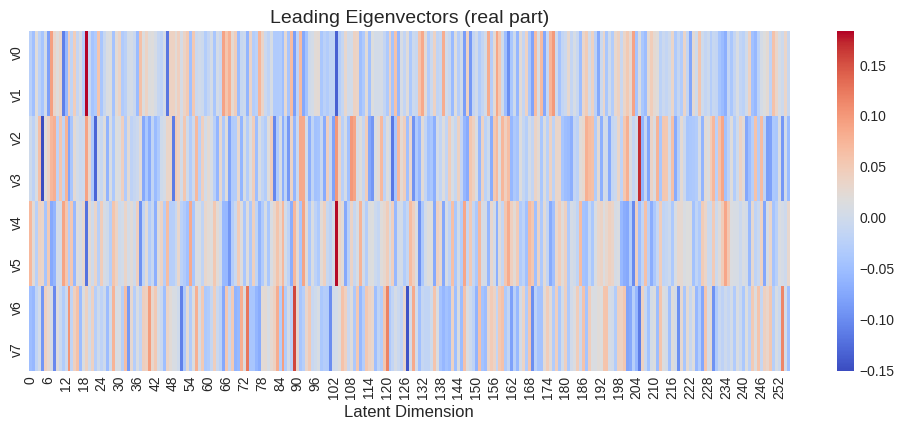

In [14]:
# Create the full Koopman matrix K = I + K_res
latent_dim = model.latent_dim
identity_matrix = np.identity(latent_dim)
K_full_matrix = K_matrix # +identity_matrix 

# Compute the eigenvalues
eigenvalues = np.linalg.eigvals(K_full_matrix)

logger.info(f"Computed {len(eigenvalues)} eigenvalues.")

# --- Visualize the Eigenvalue Spectrum ---
plt.figure(figsize=(9, 9))
ax = plt.gca()

# Plot the unit circle for reference (the stability boundary)
unit_circle = plt.Circle((0, 0), 1, color='lightgray', fill=False, linestyle='--', linewidth=2, label='Unit Circle')
ax.add_patch(unit_circle)

# Plot the eigenvalues
plt.scatter(
    eigenvalues.real,
    eigenvalues.imag,
    c=np.abs(eigenvalues),
    cmap="magma",
    marker="o",
    edgecolor="k",
    linewidth=0.5,
    zorder=3, # Plot eigenvalues on top of the circle
    label="Eigenvalues"
)

# Formatting
ax.axvline(0, color='lightgray', linestyle='-', lw=1)
ax.axhline(0, color='lightgray', linestyle='-', lw=1)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.title("Eigenvalue Spectrum of the Koopman Operator", fontsize=16)
plt.xlabel("Real Part", fontsize=12)
plt.ylabel("Imaginary Part", fontsize=12)
plt.legend()
plt.colorbar(label="Eigenvalue Magnitude |λ|")
plt.grid(True, linestyle=':')
plt.show()


# ---- 1. eigendecomposition --------------------------------------------------
evals, evecs = np.linalg.eig(K_matrix)        # evals: (n,),  evecs: (n, n)

# Convenience: sort by |λ| descending so plots are stable across runs
idx = np.argsort(np.abs(evals))[::-1]
evals = evals[idx]
evecs = evecs[:, idx]

# ---- 3. bar chart of |λ| to see spectral decay ------------------------------
plt.figure(figsize=(8, 3))
plt.bar(range(len(evals)), np.abs(evals))
plt.ylabel("|λ|")
plt.title("Magnitude of Eigenvalues (sorted)")
plt.tight_layout()
plt.show()

# ---- 4. heat-map of leading eigenvectors ------------------------------------
# stack a handful of most important modes side-by-side
modes_to_show = min(8, K_matrix.shape[0])     # tweak as you like
evec_mat = np.real(evecs[:, :modes_to_show]).T  # shape: (modes_to_show, latent_dim)

plt.figure(figsize=(10, 2 + 0.3 * modes_to_show))
sns.heatmap(evec_mat, cmap="coolwarm", cbar=True,
            yticklabels=[f"v{i}" for i in range(modes_to_show)])
plt.xlabel("Latent Dimension", fontsize=12)
plt.title("Leading Eigenvectors (real part)", fontsize=14)
plt.tight_layout()
plt.show()

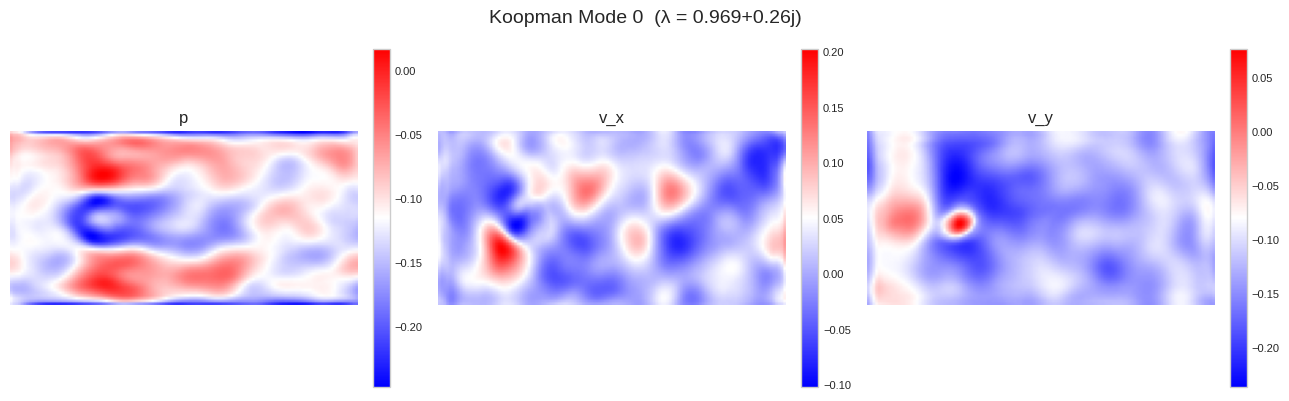

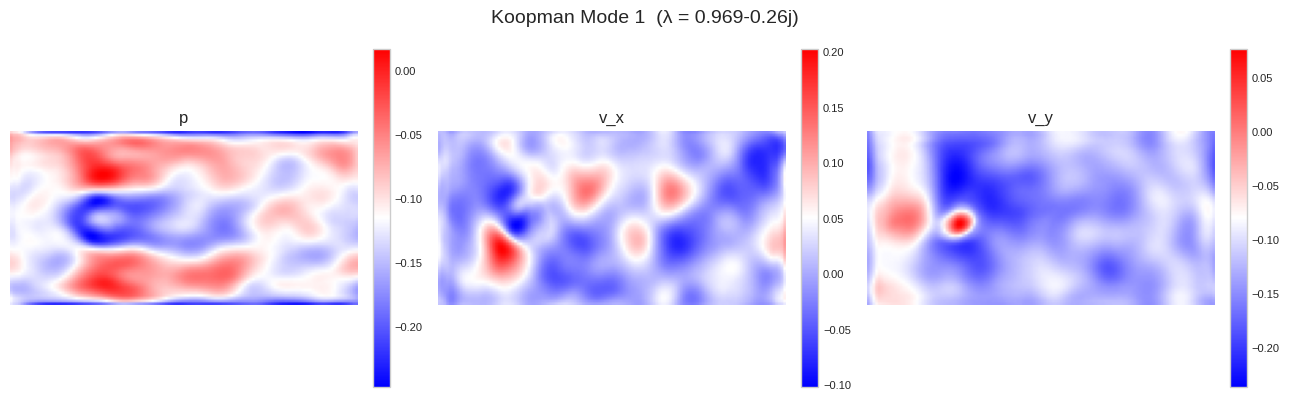

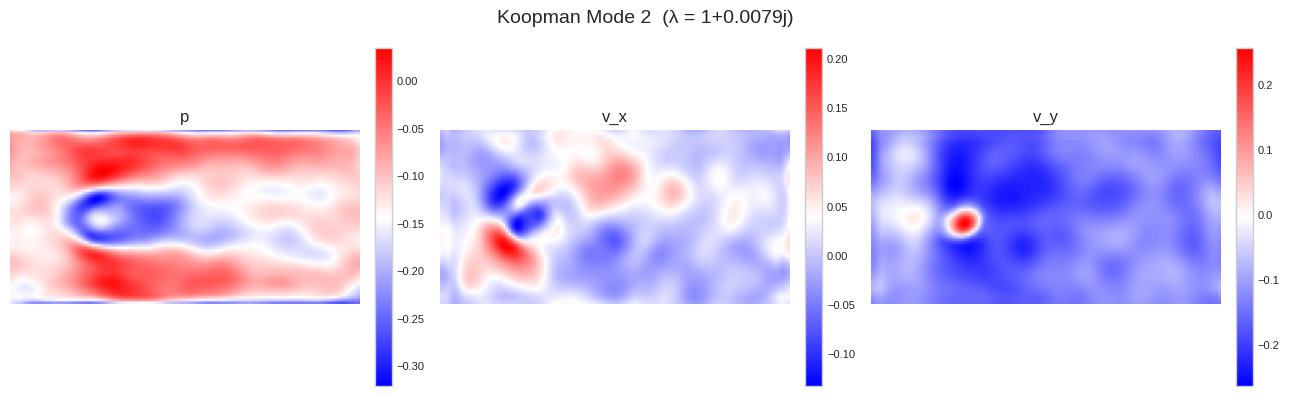

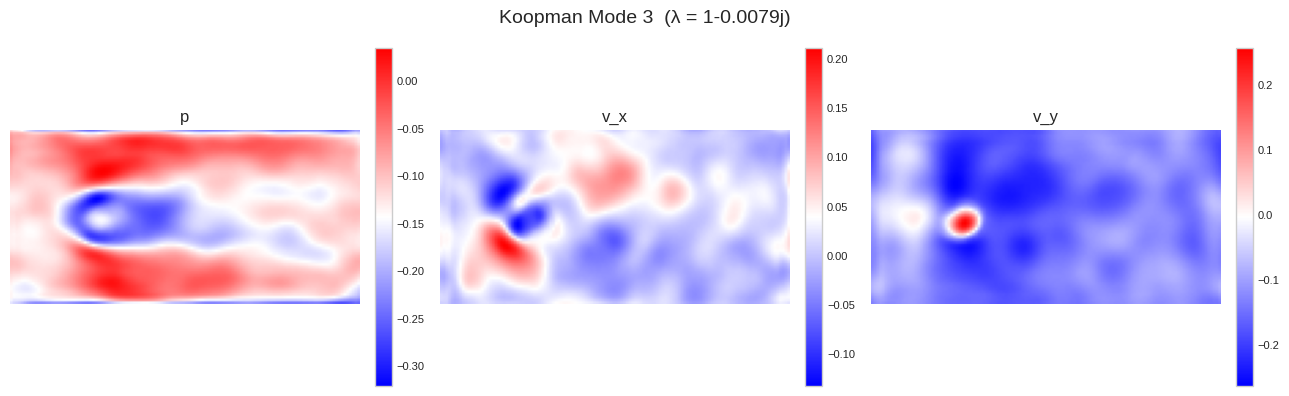

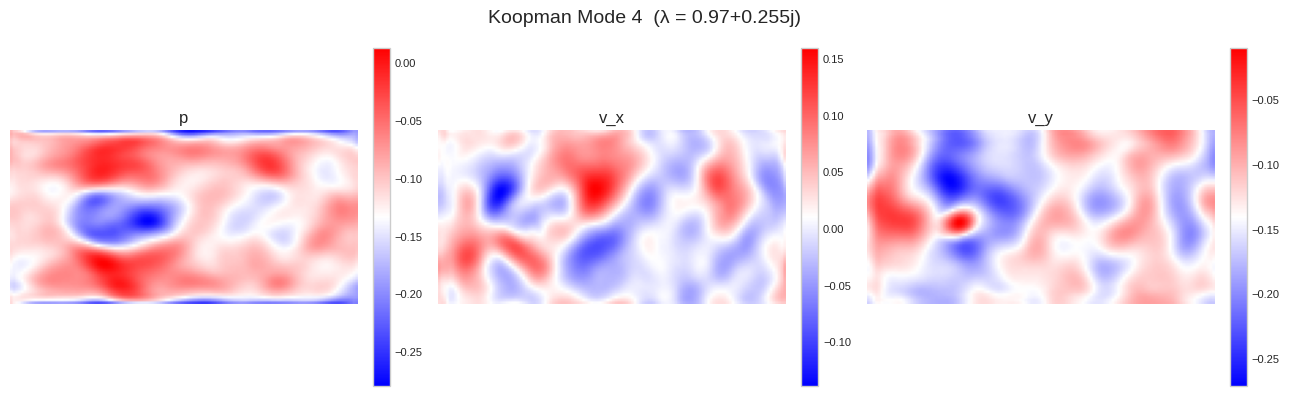

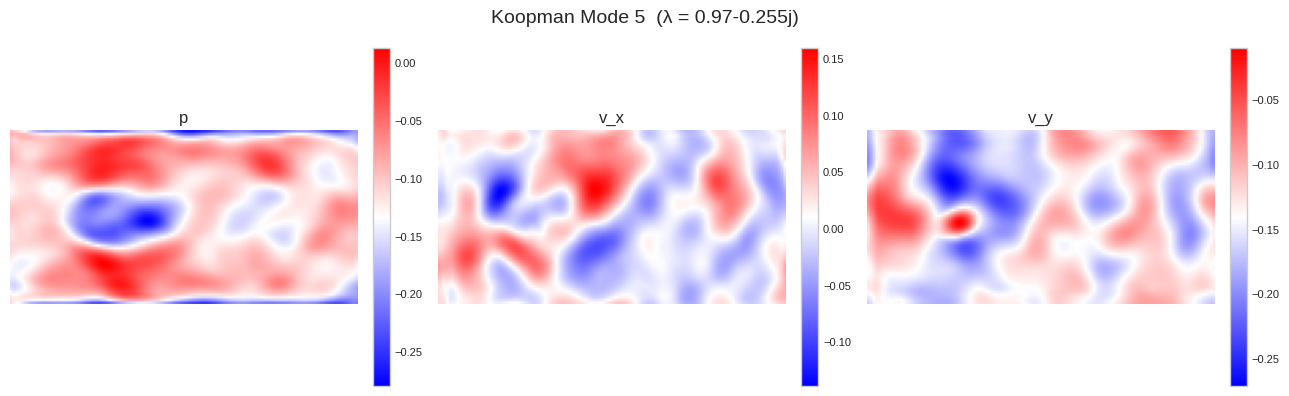

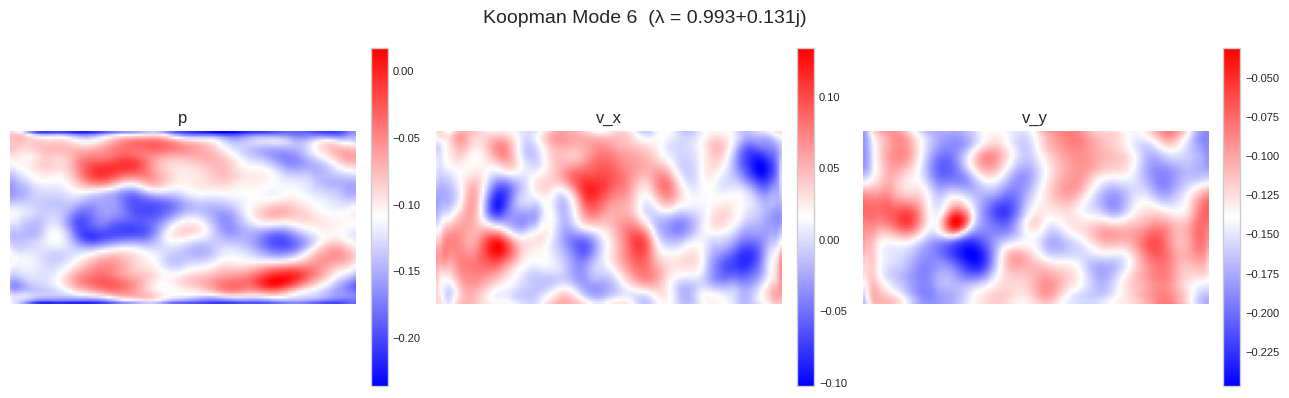

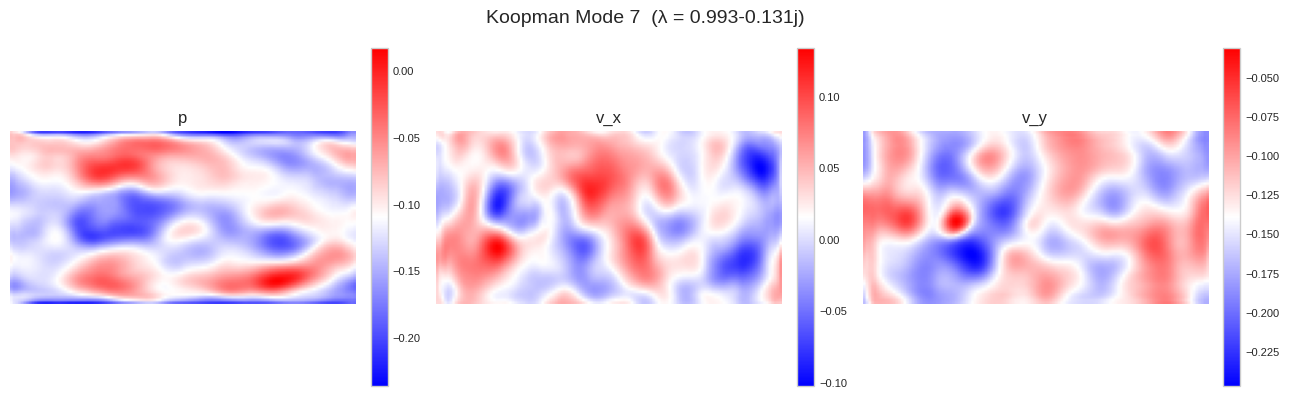

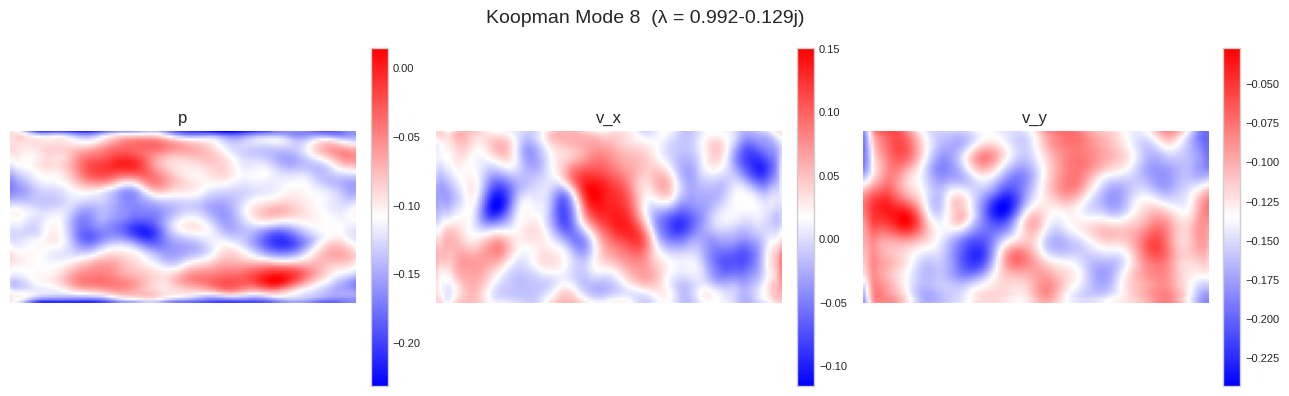

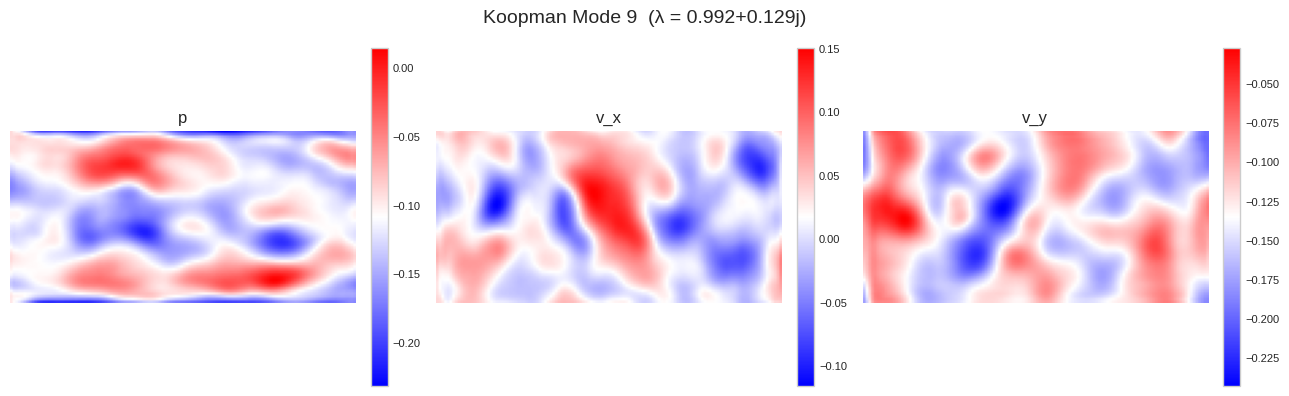

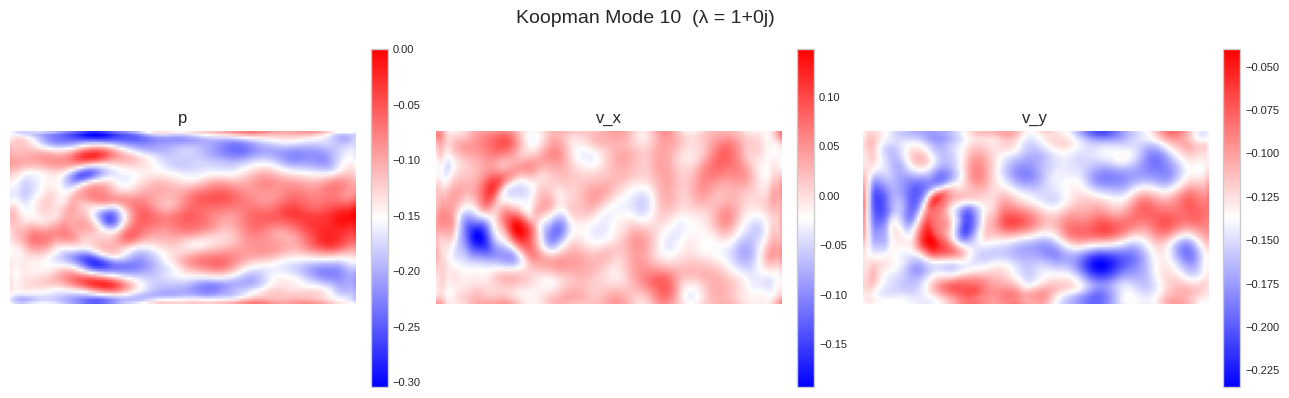

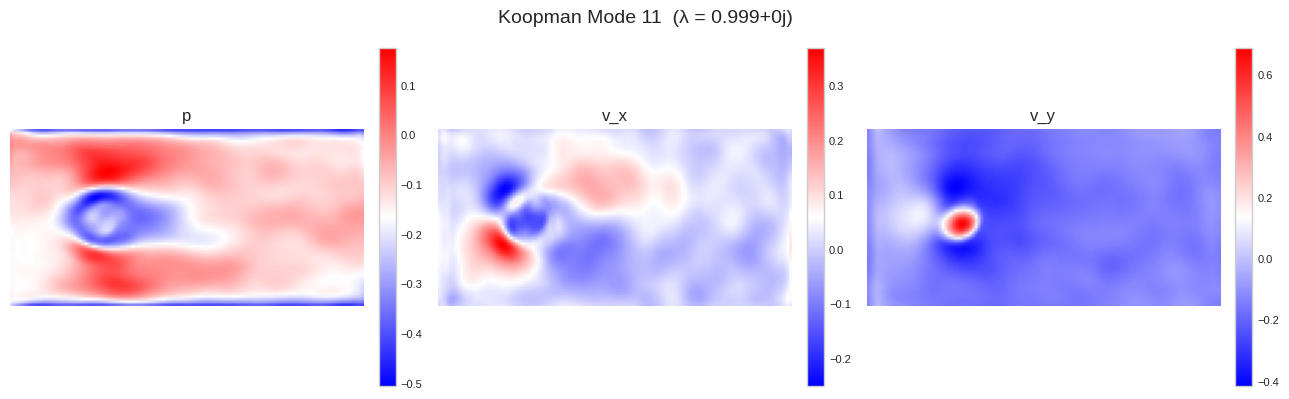

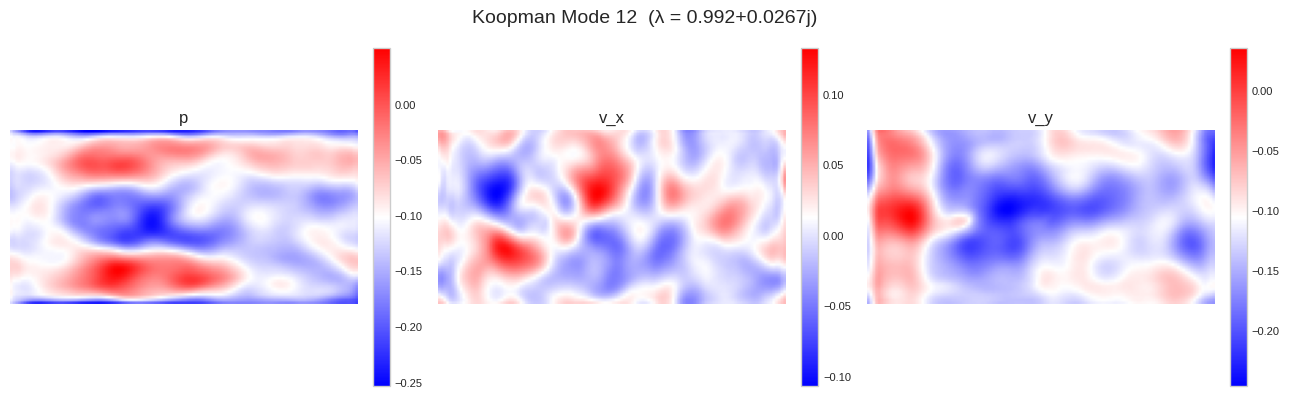

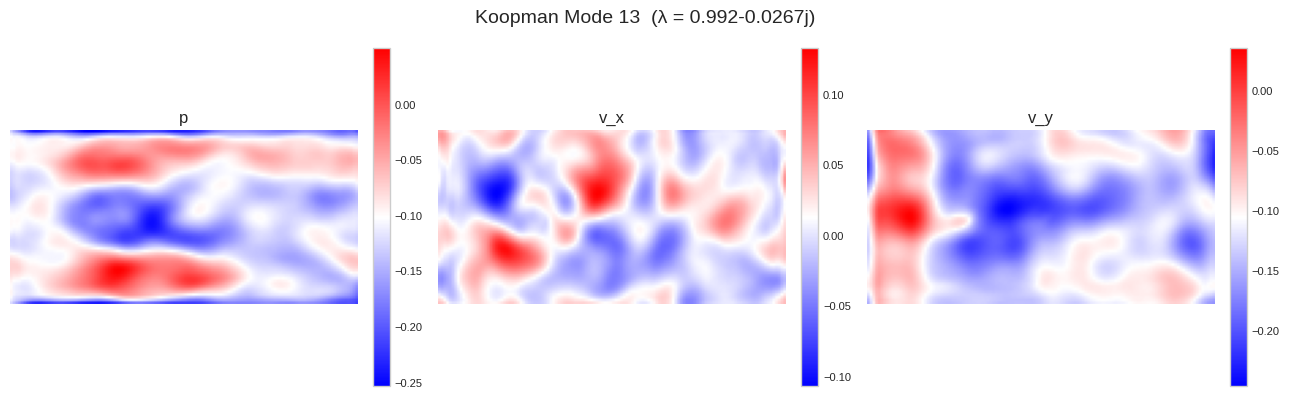

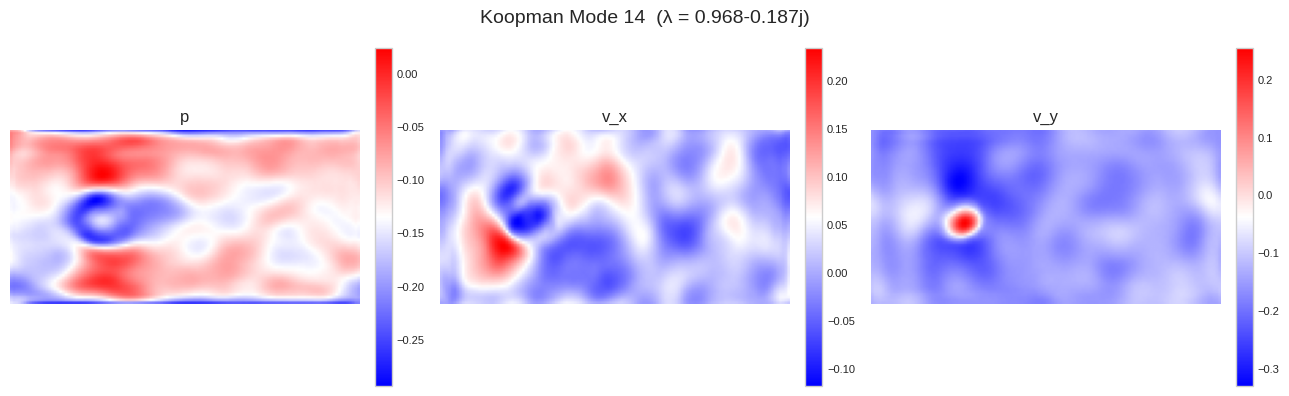

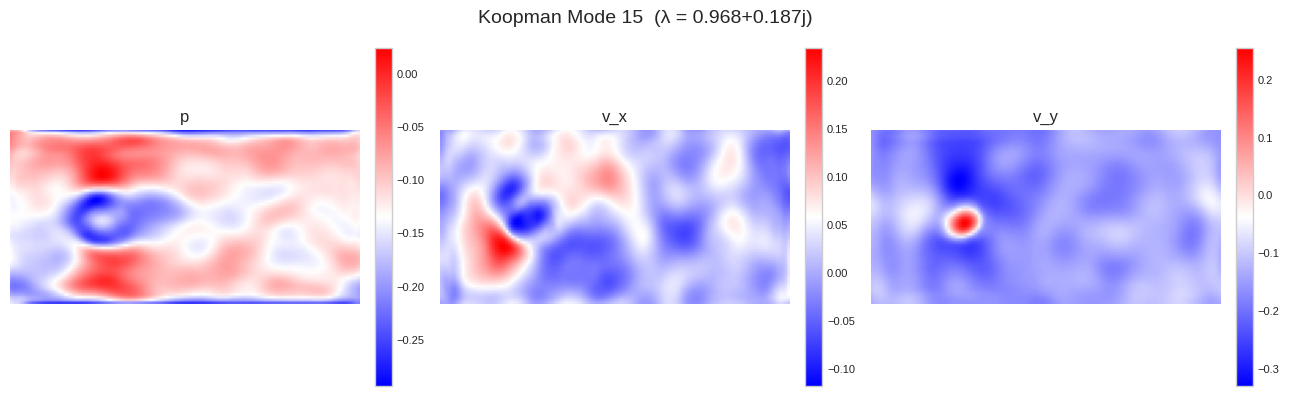

In [15]:
import torch
import matplotlib.pyplot as plt

# ---- Select a few Koopman eigenvectors to visualize (e.g. top 5) ----
num_modes = 16
latent_modes = np.real(evecs[:, :num_modes].T)  # shape: (num_modes, latent_dim)

# ---- Convert to tensor for decoding ----
latent_modes_tensor = torch.tensor(latent_modes, dtype=torch.float32).to(DEVICE)  # (num_modes, latent_dim)

# ---- Decode: map latent Koopman modes back to input space ----
with torch.no_grad():
    decoded_modes = model.decoder(latent_modes_tensor).cpu().numpy()  # shape: (num_modes, input_dim)

for i in range(num_modes):
    mode = decoded_modes[i]          # e.g. (3, 64, 128)
    λ = evals[i]

    if mode.ndim == 1:
        # 1-D signal ─ line plot (no colour map)
        plt.figure(figsize=(8, 2))
        plt.plot(mode)
        plt.title(f"Koopman Mode {i}  (λ = {λ:.3g})")
        plt.xlabel("Input Dimension")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    elif mode.ndim == 2:
        # 2-D single-channel image
        plt.figure(figsize=(4, 4))
        vmax = np.max(np.abs(mode))
        im = plt.imshow(mode, cmap="bwr", vmin=-vmax, vmax=vmax)
        plt.title(f"Koopman Mode {i}  (λ = {λ:.3g})")
        plt.axis("off")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

    elif mode.ndim == 3 and mode.shape[0] == 3:
        # 3-channel 2-D input  (e.g. RGB or u-v-w flow components)
        fig, axs = plt.subplots(1, 3, figsize=(13, 4))
        vmax = np.max(np.abs(mode))
        channel_titles = ["p", "v_x", "v_y"]

        for j in range(3):
            im = axs[j].imshow(mode[j], cmap="bwr")#, vmin=-vmax, vmax=vmax)
            axs[j].set_title(channel_titles[j])
            axs[j].axis("off")
            # one colour-bar per panel
            cb = fig.colorbar(im, ax=axs[j], fraction=0.046, pad=0.04)
            cb.ax.tick_params(labelsize=8)

        fig.suptitle(f"Koopman Mode {i}  (λ = {λ:.3g})", fontsize=14)
        plt.tight_layout()
        plt.show()

    else:
        print(f"[skip] Unhandled shape {mode.shape}")
